Observed
-----
Talk about qdpi and how you build the alleles from sequencing data and also the truth dataset.

Make the low/medium/high vaf bins and the curves

Do it again with the ultra-low separated.

Talk about how these curves have a pattern and you can imagine, well, if we had higher coverage, wouldn't the proportion which are supported increase?

Move into beta binomial distribution (you can do just a bernolli trial, but that doesn't work for whatever reasons.

Then we can match the observed 'recall' to our model to show it largely holds up.

Detour: Can we update the expected VAF based on the observed coverage? And possibly weigh the recall by the probability. The second one is a little more interesting. Like, can we better approximate how good the recall is based on our modeling? Like, if we see that of the 100 sites with VAF of 0.1, the 100x coverage says 67% of them should be supported by ≥8. If the tool is only finding 40%, then we know that there is something off about the caller.

Just a simple score can work where we measure the observed / expected percents. if it's 1, it's doing fine, > better and < worse than what's possible. If we then put our min_reads at something like 5, but allow the tools to report as little as 1 read, we can then get an idea of the tools ability to handle super low coverage.


In [4]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

full_data = pd.read_parquet("../allele_delta/data/hapmix.allele_delta.hifi.WashU.pq")
measure = full_data[(full_data['observed_vaf'] != 0)
           ].sample(5000, random_state=20)

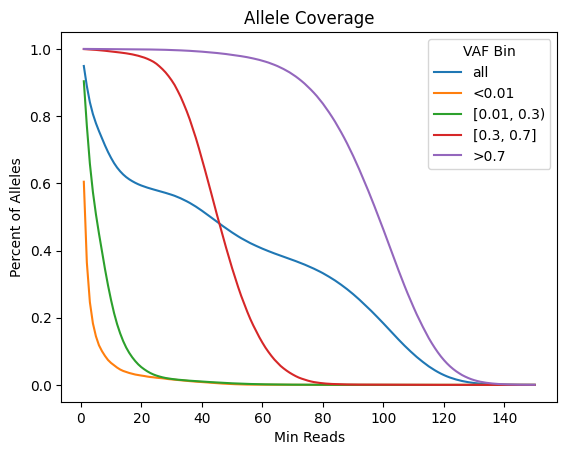

In [5]:
measure = full_data
subset = measure['expected_len'].abs() >= 0
hyper_low = measure['expected_vaf'] < 0.01
low = measure['expected_vaf'].between(0.01, 0.30, inclusive='left')
medium = measure['expected_vaf'].between(0.30, 0.70)
high = measure['expected_vaf'] > 0.70

def foo(x, min_reads, name):
    tp = (x['read_count'] >= min_reads).sum()
    total = len(x)
    fn = total - tp
    return [tp, fn, total, tp/total, min_reads, name]

rows = []
for name, df in [('all', subset), ('<0.01', hyper_low), ('[0.01, 0.3)', low), ('[0.3, 0.7]', medium), ('>0.7', high)]:
    view = measure[subset & df]
    for cov_x in range(1, 151):
        rows.append(foo(view, cov_x, name))
    
r = pd.DataFrame(rows, columns=['TP', 'FN', 'total', 'recall', "min reads", "VAF Bin"])

p = sb.lineplot(data=r, x="min reads", y="recall", hue='VAF Bin')
_ = p.set(ylabel="Percent of Alleles", xlabel="Min Reads", title="Allele Coverage")

In [6]:
view = r[r['min reads'] <= 5]
view = view.melt(id_vars = ['min reads', 'VAF Bin'], value_vars=['recall'])
(view.groupby(['min reads', 'VAF Bin'])['value'].mean().unstack() * 100).round(1)

VAF Bin,<0.01,>0.7,"[0.01, 0.3)","[0.3, 0.7]",all
min reads,,,,,
1,60.5,100.0,90.4,99.9,94.9
2,36.4,100.0,77.1,99.9,88.9
3,24.6,100.0,65.8,99.8,84.1
4,18.3,100.0,57.4,99.8,80.6
5,14.5,100.0,50.8,99.7,77.9


In [10]:
import math
import numpy as np
import scipy.special as sp
import scipy.integrate as integrate

to_analyze = measure#[subset]

def binomial_probability(vaf, coverage, min_reads):
    prob = 0
    for i in range(0, min_reads):
        binom_coeff = math.comb(coverage, i)
        prob += binom_coeff * (vaf ** i) * ((1 - vaf) ** (coverage - i))
    return 1 - prob

def beta_binomial_probability(vaf, coverage, min_reads):
    prob = 0
    alpha = coverage * vaf + 1
    beta = coverage * (1-vaf) + 1
    beta_term2 = sp.beta(alpha, beta)
    for k in range(0, min_reads):
        binom_coeff = sp.comb(coverage, k)
        beta_term1 = sp.beta(k + alpha, coverage - k + beta)
        beta_term = beta_term1 / beta_term2
        prob += binom_coeff * beta_term
    return 1 - prob

def grab_observed(vaf, min_reads):
    d = to_analyze[(to_analyze['expected_vaf'].round(2) == vaf)]
    tot = len(d)
    cov = (d['read_count'] >= min_reads).sum()
    return cov / tot, cov, tot 
                
def make_probs(vafs, coverage=100):
    rows = []
    for v in vafs:
        for k in range(0, coverage):
            obs, gt, cnt  = grab_observed(v, k)
            rows.append([v, k, gt, cnt, obs, 
                         binomial_probability(v, coverage, k), 
                         beta_binomial_probability(v, coverage, k)])
    return pd.DataFrame(rows, columns=['VAF', 'min reads', '≥', 'cnt', 'observed', 'binomial', 'beta_binomial']) 

In [11]:
predicted = make_probs([0.01, 0.05, 0.1, 0.5, 0.99])

In [12]:
view = predicted.melt(id_vars=['VAF', 'min reads'], var_name="Measure", value_name="percent", value_vars=['observed', 'binomial', 'beta_binomial'])

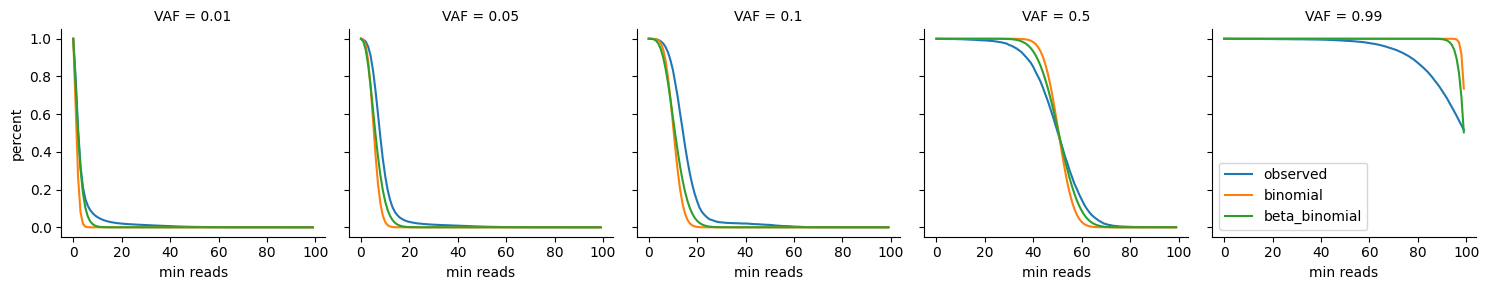

In [13]:
g = sb.FacetGrid(data=view, col='VAF', hue="Measure")
g.map(sb.lineplot, "min reads", "percent")
plt.legend()

In [14]:
from scipy.stats import pearsonr

rows = []
for name, df in predicted.groupby(['VAF']):
    rows.append((name[0], pearsonr(df['observed'], df['binomial']).statistic, 
                pearsonr(df['observed'], df['beta_binomial']).statistic))
corr = pd.DataFrame(rows, columns=['VAF', 'Obs_Bin', 'Obs_BeBin'])

In [15]:
corr

,VAF,Obs_Bin,Obs_BeBin
0,0.01,0.947404,0.994280
1,0.05,0.951213,0.983859
2,0.10,0.951977,0.976194
3,0.50,0.992661,0.997972
4,0.99,0.455307,0.635226


In [72]:
data

,chrom,start,end,expected_len,num_collapsed,read_count,observed_vaf,expected_vaf,coverage,vaf_bin,VAF delta
0,chr1,744841,744921,4.0,1,8,0.0640,0.050,125,Ultra-Low,0.0140
1,chr1,744841,744921,12.0,1,5,0.0400,0.050,125,Ultra-Low,-0.0100
2,chr1,744841,744921,17.0,2,26,0.2080,0.020,125,Ultra-Low,0.1880
3,chr1,744841,744921,25.0,4,39,0.3120,0.865,125,High,-0.5530
4,chr1,744841,744921,32.0,1,45,0.3600,0.010,125,Ultra-Low,0.3500
...,...,...,...,...,...,...,...,...,...,...,...
700259,chr9,138118071,138118618,0.0,1,100,1.0000,1.000,100,High,0.0000
700260,chr9,138123526,138123619,-8.0,1,2,0.0208,0.010,96,Ultra-Low,0.0108
700261,chr9,138123526,138123619,-2.0,3,94,0.9792,0.990,96,High,-0.0108
700262,chr9,138124679,138124771,0.0,1,2,0.0202,0.010,99,Ultra-Low,0.0102


In [76]:
data = pd.read_parquet("/Users/english/code/SMaHT_MIMS/allele_delta/data/hapmix.allele_delta.hifi.WashU.pq")
data['vafbin'] = pd.cut(data['expected_vaf'], np.linspace(0, 1, 200))
data['szbin'] = data['expected_len'].apply(lambda x: truvari.get_sizebin(x))

cnts = data['vafbin'].value_counts(sort=False)
cnts /= cnts.sum()
# change to 50 for just SVs
sv_cnts = data[data['expected_len'].abs() >= 0]['vafbin'].value_counts(sort=False)
sv_cnts /= sv_cnts.sum()
vafs = [[_.mid, sv_cnts.loc[_]] for _ in sv_cnts.index]


In [ ]:
# Let's model the frequency (count) of VAFs in the benchmark. we'll bin them in 0.005 VAFs and get the counts.
# Then we can model the expected recall.
import truvari
# SVs only
#data = pd.read_csv("/Users/english/code/SMaHT_MIMS/asm_stats/summary.smaht.single.tier1.txt.gz", sep='\t', 
#                   names=['size', 'VAF', 'AC', 'AF'])
# All Tier1 variants
data = pd.read_csv("/Users/english/code/SMaHT_MIMS/asm_stats/summary.smaht.all.txt.gz", sep='\t', 
                   names=['size', 'VAF', 'AC', 'AF'])
# 
data['vafbin'] = pd.cut(data['VAF'], np.linspace(0, 1, 200))
data['szbin'] = data['size'].apply(lambda x: truvari.get_sizebin(x))

# change to 50 for just SVs
sv_cnts = data[data['size'].abs() >= 0]['vafbin'].value_counts(sort=False)
sv_cnts /= sv_cnts.sum()
cnts = data['vafbin'].value_counts(sort=False)
cnts /= cnts.sum()
vafs = [[_.mid, sv_cnts.loc[_]] for _ in sv_cnts.index]


In [66]:
beta_binomial_probability(.01, 100, 1)

0.7487562189054863

In [28]:
def vaf_over_range(vaf_min, vaf_max, vaf_values, coverage, min_reads):
    # Calculate the beta-binomial probabilities for each VAF in the empirical data
    probabilities = []
    weights = []
    for vaf, cnt in vaf_values:
        if vaf_min <= vaf < vaf_max:
            probabilities.append(beta_binomial_probability(vaf, coverage, min_reads))
            weights.append(cnt)
    
    # Compute the weighted average of probabilities
    weighted_prob = np.average(probabilities, weights=weights)
    
    return weighted_prob

In [77]:
import json
print(json.dumps(vafs))

[[0.002515, 0.03336170358607611], [0.007565, 0.14457119029394627], [0.0126, 0.0172049398512561], [0.0176, 0.03388436361143797], [0.022600000000000002, 0.009078004866735974], [0.02765, 0.009082288965304514], [0.0327, 0.004335507751362344], [0.0377, 0.0022320153542092695], [0.0427, 0.0017878971359373036], [0.04775, 0.05820804725075115], [0.0528, 0.005582180434807444], [0.057800000000000004, 0.029764488821358803], [0.0628, 0.006283344567191802], [0.06785, 0.014618772348714199], [0.07289999999999999, 0.005563616007677105], [0.0779, 0.006614648189825552], [0.0829, 0.004332651685649984], [0.08795, 0.0027889481681194522], [0.093, 0.0026889858681868554], [0.09825, 0.005118069756548958], [0.10350000000000001, 0.001996389932939577], [0.1085, 0.004512583825528658], [0.1135, 0.0017807569716564039], [0.1185, 0.003577222304730787], [0.1235, 0.0018778632058766408], [0.1285, 0.0025276181554385203], [0.1335, 0.0020335187872002557], [0.1385, 0.0016707984417305474], [0.1435, 0.0020763597728856546], [0.14

In [31]:
print(beta_binomial_probability(0.01, 100, 0))
print(beta_binomial_probability(0.01, 100, 1))
print(beta_binomial_probability(0.01, 100, 2))

1
0.7487562189054863
0.4962499062477247


In [32]:
def make_bins(coverage, min_reads):
    print('all %.3f' % (vaf_over_range(0, 1, vafs, coverage, min_reads)))
    print('low %.3f' % (vaf_over_range(0.00, 0.3, vafs, coverage, min_reads)))
    print('medium %.3f' % (vaf_over_range(0.3, 0.7, vafs, coverage, min_reads)))
    print('high %.3f' % (vaf_over_range(0.7, 1, vafs, coverage, min_reads)))

In [84]:
# Theoretical Allele Support CDF
rows = []
for lower, upper, vaf_bin in [(0, 1, 'all'), (0, 0.01, '<0.1'), (0.01, 0.05, '[0.01, 0.05)'), 
                              (0.05, 0.30, '[0.05, 0.3)'), (0.30, 0.70, '[0.3, 0.7)'), (0.70, 1, '≥0.7)')]:
    for cov in range(1, 150):
        rows.append([vaf_bin, vaf_over_range(lower, upper, vafs, 100, cov), cov])
theo = pd.DataFrame(rows, columns=['VAF Bin', "recall", "min reads"])

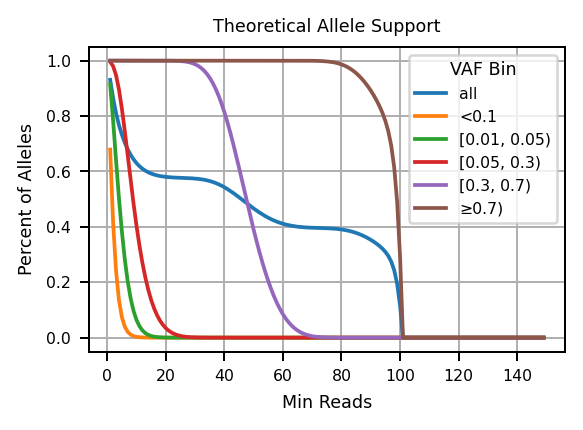

In [85]:
def scaled_fontsize(base_size, fig_width, reference_width=6.4, min_size=7):
    """
    Scales the base font size proportionally to figure width,
    but enforces a minimum font size.
    
    base_size: font size for reference_width (in inches)
    fig_width: actual figure width
    """
    scale = fig_width / reference_width
    return max(min_size, base_size * scale)


fig_width = 3.25
font_size = scaled_fontsize(base_size=12, fig_width=fig_width, min_size=7)

plt.rcParams.update({
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size * 0.9,
    "ytick.labelsize": font_size * 0.9,
    "legend.fontsize": font_size * 0.9,
})

fig, ax = plt.subplots(nrows=1, 
                       ncols=1, 
                       #figsize=(5 * len(files), 5), 
                       figsize=(3.25, 2.4), # For hifi.washu
                       squeeze=False,
                       sharex='row',
                       sharey='row',
                       dpi=180,
                      )

p = sb.lineplot(data=theo, x="min reads", y="recall", hue='VAF Bin', zorder=2, ax = ax[0][0])
_ = p.set(ylabel="Percent of Alleles", xlabel="Min Reads", 
          #title=f"Allele Coverage {tech} {center}\n(Mean Coverage {mean_cov}x)",
          title=f"Theoretical Allele Support",
         )
plt.grid()
plt.tight_layout()
plt.show()

In [54]:
measure['coverage'].describe()

count    700264.000000
mean        100.146638
std          16.242789
min           1.000000
25%          91.000000
50%         102.000000
75%         111.000000
max         314.000000
Name: coverage, dtype: float64